In [2]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable, Type
import pathlib
from pathlib import Path
import pickle as pkl

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch import Tensor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV

from models.base import FittableModule, LogisticRegression
from models.end2end import End2EndMLPResNet
from models.random_feature_representation_boosting import GradientRFRBoostClassifier
from models.gridsearch_wrapper import SKLearnWrapper

In [3]:
class Config:
    save_dir = Path.cwd() / "results" / "ConcentricCircles"

In [4]:
#######################################################
##### Create Synthetic Concentric Circles Dataset #####
#######################################################


def acc_from_logits(logits, y, n_classes):
    if n_classes==2:
        pred = (logits>0).float()
    else:
        pred = torch.argmax(logits, dim=1)
        y = torch.argmax(y, dim=1)
    acc = (pred==y).float().mean()
    return acc


def generate_concentric_rings(n_rings_per_class=2, n_classes=3, n_samples=2000, device="cpu", plot=False) -> Tuple[np.ndarray, np.ndarray]:
    X = []
    y = []
    n_rings = n_rings_per_class * n_classes
    samples_per_ring = n_samples // n_rings
    for i in range(n_rings):
        radius = i + 1
        theta = np.linspace(0, 2 * np.pi, samples_per_ring)
        noise_scale = 0.4
        x1 = radius * np.cos(theta) + np.random.rand(samples_per_ring) * noise_scale
        x2 = radius * np.sin(theta) + np.random.rand(samples_per_ring) * noise_scale
        X.append(np.vstack((x1, x2)).T)
        y.append(np.full(samples_per_ring, i % n_classes))
    X = np.vstack(X)
    y = np.hstack(y)
    perm = np.random.permutation(len(X))
    X = X[perm] / np.max(X)
    y = y[perm]

    #plot
    if plot:
        plt.figure(figsize=(8, 8))
        for i in range(n_classes):
            plt.scatter(X[y == i][:, 0], X[y == i][:, 1], label=f'Class {i}')
        plt.legend()
        plt.title('Concentric Rings Dataset')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.show()

    y = torch.tensor(y).float()
    X = torch.tensor(X).float()
    if n_classes > 2:
        y = torch.nn.functional.one_hot(y.to(torch.int64), n_classes).float()
    else:
        y = y.unsqueeze(1)

    r = int(0.5 * len(X))
    X_train, y_train, X_test, y_test = X[:r], y[:r], X[r:], y[r:]
    return (X_train.to(device),
            y_train.to(device), 
            X_test.to(device), 
            y_test.to(device) )


np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
n_classes = 3
D = 2
device = "cpu"
X_train, y_train, X_test, y_test = generate_concentric_rings(
    n_rings_per_class=3, n_classes=n_classes, n_samples=6000, device=device
    )
if n_classes > 2:
    loss_fn = nn.functional.cross_entropy
else:
    loss_fn = nn.functional.binary_cross_entropy_with_logits

In [4]:
# model = LogisticRegression(
#     n_classes, l2_lambda=0.1, max_iter=100
#      )

# results = []
# for i in range(5):
#     model.fit(X_train, y_train)
#     out_train = model(X_train)
#     out_test = model(X_test)
#     ce_train = loss_fn(out_train, y_train)
#     ce_test = loss_fn(out_test, y_test)
#     acc_train = acc_from_logits(out_train, y_train, n_classes)
#     acc_test = acc_from_logits(out_test, y_test, n_classes)
#     results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
# results = torch.stack(results)
# print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
# print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
# print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
# print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

In [5]:
# #from models.random_feature_representation_boosting import GradientRFRBoostClassifier
# from models.random_feature_representation_boosting import GradientRFRBoostClassifier

# seed=2
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)

# model = GradientRFRBoostClassifier(
#         in_dim=D,
#         n_classes=n_classes,
#         hidden_dim=2,
#         n_layers=4,
#         randfeat_xt_dim=512,
#         randfeat_x0_dim=512,
#         l2_cls=0.001,
#         l2_ghat=0.0001,
#         boost_lr=1.0,
#         feature_type="SWIM",
#         upscale_type="identity",
#         lbfgs_lr=1.0,
#         lbfgs_max_iter=300,
#         use_batchnorm=True,
#         SWIM_scale = -1.0,
#         activation = "relu",
#     )

# results = []
# for i in range(1):
#     model.fit(X_train, y_train)
#     out_train = model(X_train)
#     out_test = model(X_test)
#     ce_train = loss_fn(out_train, y_train)
#     ce_test = loss_fn(out_test, y_test)
#     acc_train = acc_from_logits(out_train, y_train, n_classes)
#     acc_test = acc_from_logits(out_test, y_test, n_classes)
#     results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
# results = torch.stack(results)
# print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
# print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
# print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
# print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

In [6]:
# def plot_features(X_train, y_train, X_test, y_test):
#         plt.figure(figsize=(12, 6))

#         if y_train.size(1) == 1:
#             y_train = torch.nn.functional.one_hot(y_train[:, 0].to(torch.int64), 2).float()
#             y_test = torch.nn.functional.one_hot(y_test[:, 0].to(torch.int64), 2).float()

#         X_train = X_train.cpu().numpy()
#         y_train = y_train.cpu().numpy()
#         X_test = X_test.cpu().numpy()
#         y_test = y_test.cpu().numpy()

#         alpha = 0.5  # Set the transparency level

#         plt.subplot(1, 2, 1)
#         for i in range(n_classes):
#             plt.scatter(X_train[y_train[:, i] == 1][:, 0], X_train[y_train[:, i] == 1][:, 1], label=f'Class {i}', alpha=alpha)
#         plt.title('Training Data')
#         plt.xlabel('x1')
#         plt.ylabel('x2')
#         plt.legend()

#         plt.subplot(1, 2, 2)
#         for i in range(n_classes):
#             plt.scatter(X_test[y_test[:, i] == 1][:, 0], X_test[y_test[:, i] == 1][:, 1], label=f'Class {i}', alpha=alpha)
#         plt.title('Test Data')
#         plt.xlabel('x1')
#         plt.ylabel('x2')
#         plt.legend()

#         plt.show()


# def see_results_for_every_layer(X_train, y_train, X_test, y_test, model, loss_fn):
#     with torch.no_grad():
#         X0_train = X_train
#         X0_test = X_test

#         X_train = model.upscale(X0_train)
#         X_test = model.upscale(X0_test)

#         pred_train = model.top_level_modules[0](X_train)
#         pred_test = model.top_level_modules[0](X_test)

#         ce_train = loss_fn(pred_train, y_train)
#         ce_test = loss_fn(pred_test, y_test)
#         acc_train = acc_from_logits(pred_train, y_train, n_classes)
#         acc_test = acc_from_logits(pred_test, y_test, n_classes)
#         print(f"Train ce at layer 0: {ce_train}")
#         print(f"Test ce at layer 0: {ce_test}")
#         print(f"Train acc at layer 0: {acc_train}")
#         print(f"Test acc at layer 0: {acc_test}")
#         print()
#         plot_features(X_train, y_train, X_test, y_test)
        
#         for t, (feat_layer, ghat_layer, classifier, batchnorm) in enumerate(zip(model.random_feature_layers, 
#                                                                      model.ghat_boosting_layers, 
#                                                                      model.top_level_modules[1:],
#                                                                      model.batchnorms)):
#             features_train = feat_layer(X_train, X0_train)
#             features_test = feat_layer(X_test, X0_test)
#             X_train = X_train + model.boost_lr * ghat_layer(features_train)
#             X_train = batchnorm(X_train)
#             X_test = X_test + model.boost_lr * ghat_layer(features_test)
#             X_test = batchnorm(X_test)
            
#             pred_train = classifier(X_train)
#             pred_test = classifier(X_test)

#             ce_train = loss_fn(pred_train, y_train)
#             ce_test = loss_fn(pred_test, y_test)
#             acc_train = acc_from_logits(pred_train, y_train, n_classes)
#             acc_test = acc_from_logits(pred_test, y_test, n_classes)

#             print(f"Train ce at layer {t+1}: {ce_train}")
#             print(f"Test ce at layer {t+1}: {ce_test}")
#             print(f"Train acc at layer {t+1}: {acc_train}")
#             print(f"Test acc at layer {t+1}: {acc_test}")
#             print()
#             plot_features(X_train, y_train, X_test, y_test)

# see_results_for_every_layer(X_train, y_train, X_test, y_test, model, loss_fn)


# End2End

In [7]:
# from models.end2end import End2EndMLPResNet

# n_blocks = 4
# model = End2EndMLPResNet(
#         in_dim=2,
#         hidden_dim=2,
#         bottleneck_dim=512,
#         out_dim= (n_classes if n_classes>2 else 1),
#         n_blocks=n_blocks,
#         loss = ("cce" if n_classes>2 else "bce"),
#         lr = 0.001,
#         n_epochs = 30,
#         end_lr_factor= 0.01,
#         weight_decay = 0.00001,
#         batch_size = 128,
#         upsample = False,
#         activation = nn.ReLU(),
#         )

# results = []
# for i in range(1):
#     model.fit(X_train, y_train)
#     model.eval()
#     out_train = model(X_train)
#     out_test = model(X_test)
#     ce_train = loss_fn(out_train, y_train)
#     ce_test = loss_fn(out_test, y_test)
#     acc_train = acc_from_logits(out_train, y_train, n_classes)
#     acc_test = acc_from_logits(out_test, y_test, n_classes)
#     results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
# results = torch.stack(results)
# print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
# print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
# print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
# print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

In [8]:
# def plot_resnet(X_train, y_train, X_test, y_test, model):
#     with torch.no_grad():
#         # for each layer, calculate the activations, and plot
#         X_train = model.upsample(X_train)
#         X_test = model.upsample(X_test)
#         plot_features(X_train, y_train, X_test, y_test)

#         for t in range(n_blocks):
#             X_train = X_train + model.residual_blocks[t](X_train)
#             X_test = X_test + model.residual_blocks[t](X_test)
#             plot_features(X_train, y_train, X_test, y_test)
# plot_resnet(X_train, y_train, X_test, y_test, model)

# How do i want to set up the experiments?

In [ ]:
import json

def save_feature_plot(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        model, 
        n_classes, 
        file_name: str,
        ):
    """
    Saves train and test features side by side for visualization at a given layer.
    
    Args:
        X_train (torch.Tensor): Features of the training set (shape: [n_samples, 2]).
        y_train (torch.Tensor): Labels of the training set (one-hot or integer-encoded).
        X_test (torch.Tensor): Features of the test set (shape: [n_samples, 2]).
        y_test (torch.Tensor): Labels of the test set (one-hot or integer-encoded).
        n_classes (int): Number of classes in the dataset.
        file_name (str): Name of the file to save the plot.
    """
    # Obtain the features at each layer
    train_features = [X_train]
    test_features = [X_test]
    if type(model) == GradientRFRBoostClassifier:
        X0_train = X_train
        X0_test = X_test
        for t, (feat_layer, ghat_layer, batchnorm) in enumerate(zip(model.random_feature_layers, 
                                                                     model.ghat_boosting_layers, 
                                                                     model.batchnorms)):
            model.train()
            features_train = feat_layer(X_train, X0_train)
            X_train = X_train + model.boost_lr * ghat_layer(features_train)
            X_train = batchnorm(X_train)
            model.eval()
            features_test = feat_layer(X_test, X0_test)
            X_test = X_test + model.boost_lr * ghat_layer(features_test)
            X_test = batchnorm(X_test)
            train_features.append(X_train)
            test_features.append(X_test)
    elif type(model) == End2EndMLPResNet:
        for resblock in model.residual_blocks:
            model.train()
            X_train = X_train + resblock(X_train)
            model.eval()
            X_test = X_test + resblock(X_test)
            train_features.append(X_train)
            test_features.append(X_test)
    else:
        raise ValueError("Model type not recognized.")
    
    # Convert labels to integers if they're one-hot encoded
    train_labels_np = y_train.argmax(dim=1).cpu().numpy() if n_classes > 2 else y_train.cpu().numpy()
    test_labels_np = y_test.argmax(dim=1).cpu().numpy() if n_classes > 1 else y_test.cpu().numpy()

    # Plot the features
    fontsize=30
    name = "MLP ResNet" if type(model) == End2EndMLPResNet else "GRFRBoost"
    custom_cmap = ListedColormap(['#ff7f0e', '#2ca02c', '#1f77b4'])  # Orange, Green, Blue
    T = len(train_features)
    for name_train_or_test, features, labels in [("train", train_features, train_labels_np), 
                                                 ("test", test_features, test_labels_np)]:
        fig, axes = plt.subplots(1, T, figsize=(T * 4, 4), dpi=100)
        for t in range(T):
            ax = axes[t]
            feat = features[t].detach().cpu().numpy()

            ax.scatter(feat[:, 0], feat[:, 1], c=labels, cmap=custom_cmap, s=40, alpha=0.5, edgecolors='none')

            # Remove titles and adjust axis
            ax.axis('equal')
            ax.axis('off')

            # Add black border as a rectangle
            rect = patches.Rectangle(
                (0, 0), 1, 1, transform=ax.transAxes,  # Set size relative to axes
                linewidth=2, edgecolor='black', facecolor='none', zorder=10
            )
            ax.add_patch(rect)

        # Add vertical label for the model name
        if name == "GRFRBoost":
            if model.feature_type == "SWIM":
                name = name +" SWIM"
            else:
                name = name +" iid"
        fig.text(0.015, 0.5, name, fontsize=fontsize, rotation='vertical', va='center', ha='center')

        plt.tight_layout()
        plt.subplots_adjust(left=0.03)  # Add space for the model name
        plt.savefig(Config.save_dir / f"{file_name}_{name_train_or_test}.png", bbox_inches='tight', dpi=300)
        # plt.savefig(Config.save_dir / f"{file_name}_{name_train_or_test}.eps", bbox_inches='tight')
        plt.close(fig)



def run_concentric_rings_experiment(
        seed=0,
        k_folds=5,
        n_classes=3,
        n_rings_per_class=3,
        n_samples=10000, #10000 gives good image
        device="cpu",
        ):
    """Runs the concentric circle experiments and saves the plots and results."""
    # Define models and their hyperparameter grids
    n_layers = 3
    bottleneck_dim = 512
    use_batchnorm = True
    do_linesearch = True
    model_specs = {
        "RFRBoost SWIM": {
            'modelClass': [GradientRFRBoostClassifier],
            'l2_cls': np.logspace(-4, 0, 5),
            'l2_ghat': [1e-5],
            'in_dim': [2],
            'n_classes': [n_classes],
            'hidden_dim': [2],
            'n_layers': [n_layers],
            'randfeat_xt_dim': [bottleneck_dim],
            'randfeat_x0_dim': [bottleneck_dim],
            'upscale_type': ["identity"],
            'feature_type': ["SWIM"],
            'SWIM_scale': [1.0],
            'activation': ["tanh"],
            "do_linesearch": [do_linesearch],
            "use_batchnorm": [use_batchnorm],
            "boost_lr": [0.1],
        },
        "RFRBoost iid": {
            'modelClass': [GradientRFRBoostClassifier],
            'l2_cls': np.logspace(-4, 0, 5),
            'l2_ghat': [1e-5],
            'in_dim': [2],
            'n_classes': [n_classes],
            'hidden_dim': [2],
            'n_layers': [n_layers],
            'randfeat_xt_dim': [bottleneck_dim],
            'randfeat_x0_dim': [bottleneck_dim],
            'upscale_type': ["identity"],
            'feature_type': ["iid"],
            'activation': ["tanh"],
            'iid_scale': [10.0],
            "do_linesearch": [do_linesearch],
            "use_batchnorm": [use_batchnorm],
            "boost_lr": [0.1],
        },
        "Logistic Regression": {
            'modelClass': [LogisticRegression],
            'l2_lambda': np.logspace(-4, 0, 5),
            'n_classes': [n_classes],
        },
        "End2EndMLP": {
            'modelClass': [End2EndMLPResNet],
            'lr': np.logspace(-6, -1, 6),
            'lr': [0.01],
            'in_dim': [2],
            'hidden_dim': [2],
            'bottleneck_dim': [bottleneck_dim],
            'out_dim': [n_classes if n_classes > 2 else 1],
            'n_blocks': [n_layers],
            'loss': ["cce" if n_classes > 2 else "bce"],
            'n_epochs': [30],
            'end_lr_factor': [0.01],
            'weight_decay': [0.00001],
            'batch_size': [64],
            'upsample': [False],
            'activation': [nn.Tanh()],
        },
        "RFNN": {
            'modelClass': [GradientRFRBoostClassifier],
            'l2_cls': np.logspace(-4, 0, 5),
            'in_dim': [2],
            'n_classes': [n_classes],
            'hidden_dim': [512],
            'n_layers': [0],
            'upscale_type': ["SWIM"],
            'SWIM_scale': [1.0],
            'activation': ["tanh"],
        },
        "RFNN iid": {
            'modelClass': [GradientRFRBoostClassifier],
            'l2_cls': np.logspace(-4, 0, 5),
            'in_dim': [2],
            'n_classes': [n_classes],
            'hidden_dim': [512],
            'n_layers': [0],
            'upscale_type': ["iid"],
            'iid_scale': [10.0],
            'activation': ["tanh"],
        },
    }

    # Run experiments
    results = {}
    results_params = {}
    for model_name, param_grid in model_specs.items():
        accuracies = []
        best_params = []
        for i in range(1):
            # Set seed
            np.random.seed(seed+i)
            torch.manual_seed(seed+i)
            torch.cuda.manual_seed(seed+i)

            # Create dataset
            X_train, y_train, X_test, y_test = generate_concentric_rings(
                n_rings_per_class, n_classes, n_samples, device
            )

            # Perform grid search with k-fold cross-validation
            estimator = SKLearnWrapper()
            grid_search = GridSearchCV(
                estimator=estimator,
                param_grid= {**param_grid, **{"seed": [seed+i]}},
                cv=5,
                #scoring="neg_log_loss", #use default .score instead
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_model.set_model_eval()
            accuracy = best_model.score(X_test, y_test)
            accuracies.append(accuracy)
            best_params.append(grid_search.best_params_)

            print(i, model_name, "test acc", accuracy, "params", grid_search.best_params_)

            if i == 0 and ("RFRBoost" in model_name or "MLP" in model_name):
                print("plotting and saving feature evolution point cloud")
                save_feature_plot(X_train, y_train, X_test, y_test, best_model.model, n_classes, model_name)
        results[model_name] = accuracies
        results_params[model_name] = best_params

    # Save results to a file
    with open(Config.save_dir / f"combined_results.pkl", "wb") as f:
        pkl.dump(results, f)

    return results, results_params

results, results_params = run_concentric_rings_experiment()

for model_name, accs in results.items():
    print(model_name, "acc", np.mean(accs), "std", np.std(accs))
    print(accs)
    print()
for model_name, best_params in results_params.items():
    print(model_name, "best params", best_params)
    print()

0 RFRBoost SWIM test acc 0.9980000257492065 params {'SWIM_scale': 1.0, 'activation': 'tanh', 'boost_lr': 0.1, 'do_linesearch': True, 'feature_type': 'SWIM', 'hidden_dim': 2, 'in_dim': 2, 'l2_cls': 0.1, 'l2_ghat': 1e-05, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 3, 'n_layers': 3, 'randfeat_x0_dim': 512, 'randfeat_xt_dim': 512, 'seed': 0, 'upscale_type': 'identity', 'use_batchnorm': True}
plotting and saving feature evolution point cloud
0 RFRBoost iid test acc 1.0 params {'activation': 'tanh', 'boost_lr': 0.1, 'do_linesearch': True, 'feature_type': 'iid', 'hidden_dim': 2, 'iid_scale': 10.0, 'in_dim': 2, 'l2_cls': 0.1, 'l2_ghat': 1e-05, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 3, 'n_layers': 3, 'randfeat_x0_dim': 512, 'randfeat_xt_dim': 512, 'seed': 0, 'upscale_type': 'identity', 'use_batchnorm': True}
plotting and saving feature evolution point cloud

100%|██████████| 30/30 [00:06<00:00,  4.82it/s]


0 End2EndMLP test acc 0.5827999711036682 params {'activation': Tanh(), 'batch_size': 128, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 2, 'in_dim': 2, 'loss': 'cce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 3, 'n_epochs': 30, 'out_dim': 3, 'seed': 0, 'upsample': False, 'weight_decay': 1e-05}
plotting and saving feature evolution point cloud
0 RFNN test acc 0.8873999714851379 params {'SWIM_scale': 1.0, 'activation': 'tanh', 'hidden_dim': 512, 'in_dim': 2, 'l2_cls': 0.0001, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 3, 'n_layers': 0, 'seed': 0, 'upscale_type': 'SWIM'}


In [10]:
with open(Config.save_dir / "combined_results.pkl", "rb") as f:
    results = pkl.load(f)

In [11]:
results

{'RFRBoost SWIM': [0.998199999332428,
  0.9973999857902527,
  0.9980000257492065,
  0.9940000176429749,
  0.9980000257492065,
  0.9986000061035156,
  0.9955999851226807,
  0.9987999796867371,
  0.9987999796867371,
  0.9990000128746033],
 'RFRBoost iid': [1.0,
  0.9987999796867371,
  1.0,
  0.9998000264167786,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'Logistic Regression': [0.33160001039505005,
  0.2863999903202057,
  0.35120001435279846,
  0.32919999957084656,
  0.33399999141693115,
  0.32499998807907104,
  0.328000009059906,
  0.3555999994277954,
  0.32420000433921814,
  0.3070000112056732],
 'End2EndMLP': [0.5425999760627747,
  0.5335999727249146,
  0.5968000292778015,
  0.4083999991416931,
  0.4156000018119812,
  0.4075999855995178,
  0.5655999779701233,
  0.5608000159263611,
  0.3630000054836273,
  0.79339998960495],
 'RFNN': [0.8873999714851379,
  0.8622000217437744,
  0.9128000140190125,
  0.852400004863739,
  0.9168000221252441,
  0.8628000020980835,
  0.876800000667572,
  0.

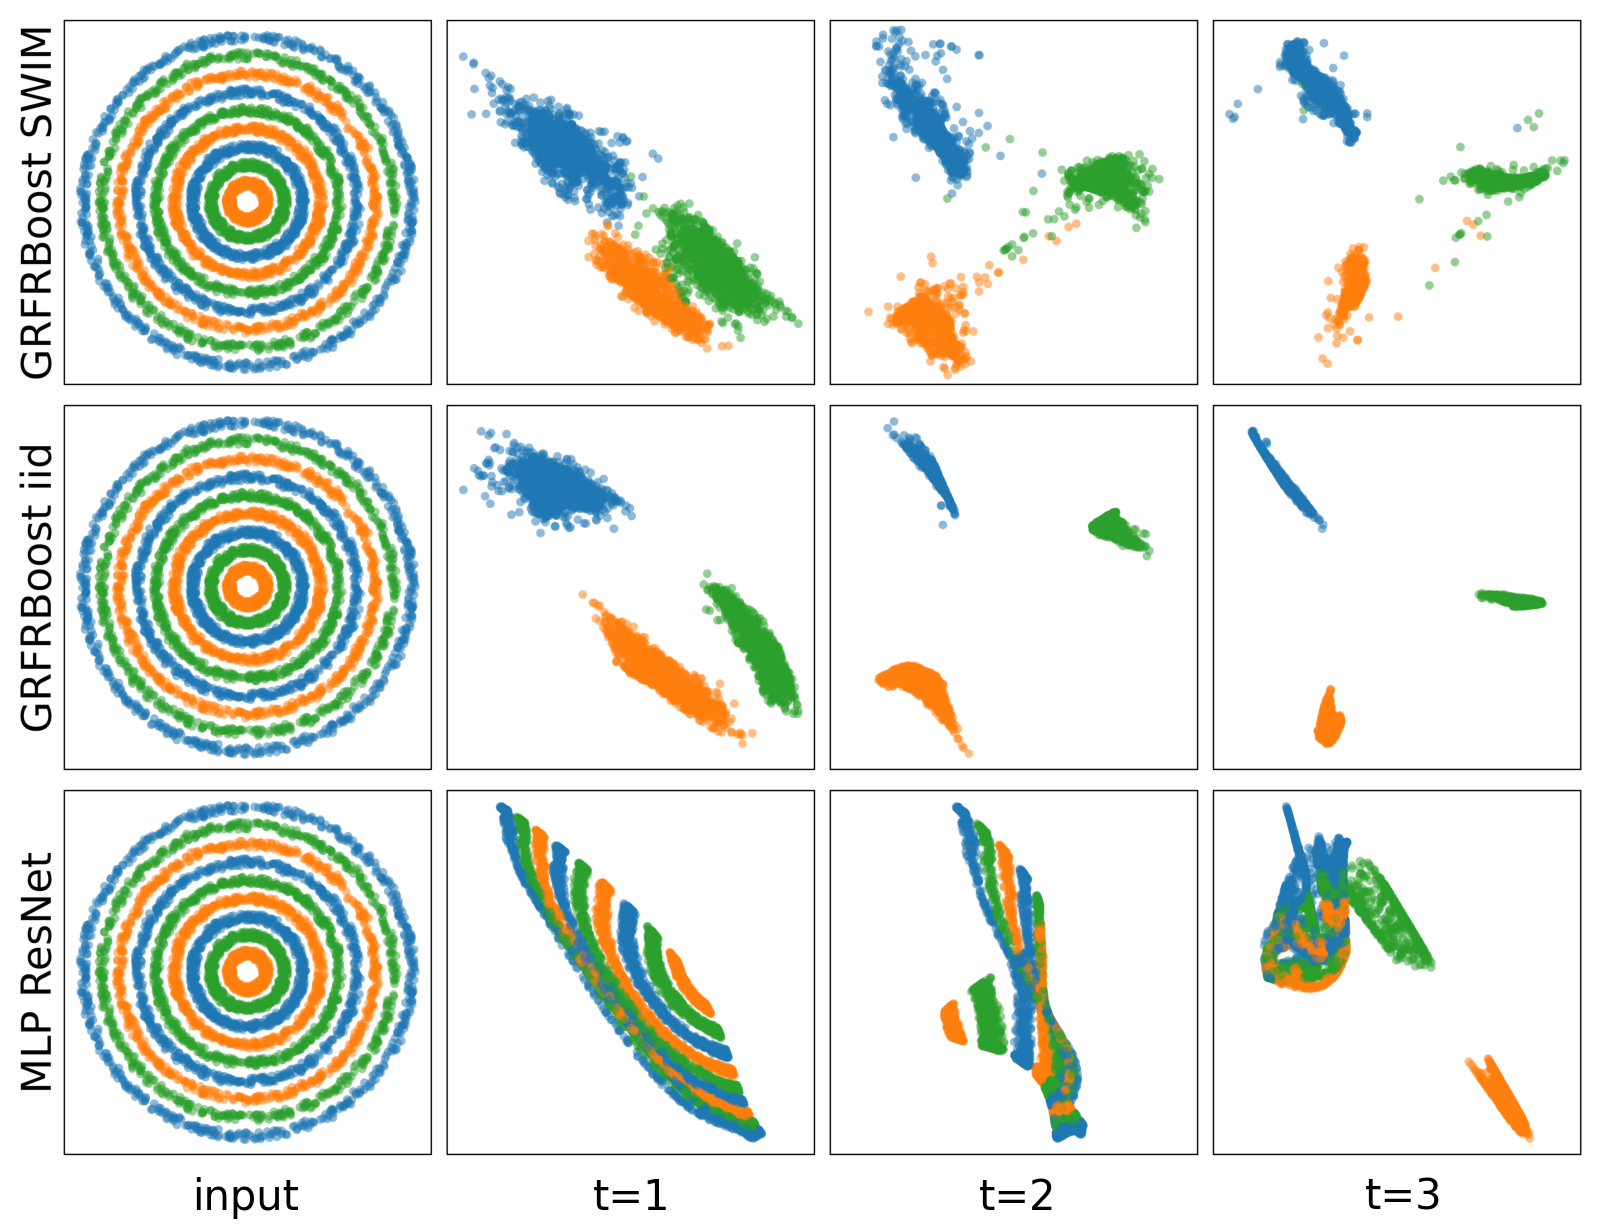

In [12]:
def make_combined_plot():
    # List of image paths
    plots = [
        "results/ConcentricCircles/RFRBoost SWIM_test.png",
        "results/ConcentricCircles/RFRBoost iid_test.png",
        "results/ConcentricCircles/End2EndMLP_test.png"
    ]

    # Create a figure to hold the subplots
    fig, axes = plt.subplots(len(plots), 1, figsize=(30, 15))

    # Loop through the images and add them to the subplots
    for ax, plot in zip(axes, plots):
        img = mpimg.imread(plot)
        ax.imshow(img)
        ax.axis('off')  # Hide the axes

    # Add text below the subplots
    left_indent = 0.315
    height = 0.08
    fig.text(left_indent, height, 'input', ha='center', fontsize=30)
    for t in range(1, 3+1):
        fig.text(left_indent + t/4*0.515, height, f't={t}', ha='center', fontsize=30)

    # Adjust layout to avoid overlap and reduce vertical space
    plt.subplots_adjust(left=0.01, right=0.99, hspace=0.0001)
    plt.savefig("results/ConcentricCircles/ConcentricEvolution.png", bbox_inches='tight')
    plt.show()
    plt.close()

make_combined_plot()

In [13]:
for model_name, accs in results.items():
    print(model_name, "acc", np.mean(accs), "std", np.std(accs))
    print(accs)
    print()
for model_name, best_params in results_params.items():
    print(model_name, "best params", best_params)
    print()


RFRBoost SWIM acc 0.9976400017738343 std 0.0015330990802179128
[0.998199999332428, 0.9973999857902527, 0.9980000257492065, 0.9940000176429749, 0.9980000257492065, 0.9986000061035156, 0.9955999851226807, 0.9987999796867371, 0.9987999796867371, 0.9990000128746033]

RFRBoost iid acc 0.9998600006103515 std 0.0003583350241339456
[1.0, 0.9987999796867371, 1.0, 0.9998000264167786, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Logistic Regression acc 0.3272200018167496 std 0.018813072600752805
[0.33160001039505005, 0.2863999903202057, 0.35120001435279846, 0.32919999957084656, 0.33399999141693115, 0.32499998807907104, 0.328000009059906, 0.3555999994277954, 0.32420000433921814, 0.3070000112056732]

End2EndMLP acc 0.5187399953603744 std 0.12070887353105597
[0.5425999760627747, 0.5335999727249146, 0.5968000292778015, 0.4083999991416931, 0.4156000018119812, 0.4075999855995178, 0.5655999779701233, 0.5608000159263611, 0.3630000054836273, 0.79339998960495]

RFNN acc 0.87814000248909 std 0.027435170129586194
[0.88739

In [14]:
def create_latex_table(results):
    table = """
\\begin{table}[t]
\\caption{Test accuracies on the concentric circles task.}
\\label{tab:concentric-circles}
\\vskip 0.15in
\\begin{center}
\\begin{small}
\\begin{sc}
\\begin{tabular}{lcc}
\\toprule
Model & Mean Acc & Std Dev \\\\
\\midrule
"""
    for model_name, accs in results.items():
        mean_acc = np.mean(accs)
        std_acc = np.std(accs)
        table += f"{model_name} & {mean_acc:.4f} & {std_acc:.4f} \\\\\n"
    
    table += """
\\bottomrule
\\end{tabular}
\\end{sc}
\\end{small}
\\end{center}
\\vskip -0.1in
\\end{table}
"""
    return table

# Example usage
latex_table = create_latex_table(results)
print(latex_table)


\begin{table}[t]
\caption{Test accuracies on the concentric circles task.}
\label{tab:concentric-circles}
\vskip 0.15in
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{lcc}
\toprule
Model & Mean Acc & Std Dev \\
\midrule
RFRBoost SWIM & 0.9976 & 0.0015 \\
RFRBoost iid & 0.9999 & 0.0004 \\
Logistic Regression & 0.3272 & 0.0188 \\
End2EndMLP & 0.5187 & 0.1207 \\
RFNN & 0.8781 & 0.0274 \\
RFNN iid & 0.4447 & 0.0125 \\

\bottomrule
\end{tabular}
\end{sc}
\end{small}
\end{center}
\vskip -0.1in
\end{table}



In [18]:
name = "RFRBoost SWIM"
print(name)
for params in results_params[name]:
    print("l2_cls", params["l2_cls"])

for params in results_params[name]:
    print("l2_ghat", params["l2_ghat"])


# change --- l2_cls 1 to 0.001
#            l2_ghat 0.001 to 1e-06 (i think this is what ia lready have...)

RFRBoost SWIM
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05


In [19]:
name = "RFRBoost iid"
print(name)
for params in results_params[name]:
    print("l2_cls", params["l2_cls"])

for params in results_params[name]:
    print("l2_ghat", params["l2_ghat"])

# change --- l2_cls 0.01 to 0.00001
#            l2_ghat 0.001 to 0.000001

RFRBoost iid
l2_cls 0.1
l2_cls 0.1
l2_cls 0.01
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_cls 0.1
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 1e-05


In [20]:
name = "End2EndMLP"
print(name)
for params in results_params[name]:
    print("lr", params["lr"])

End2EndMLP
lr 0.01
lr 0.01
lr 0.01
lr 0.01
lr 0.01
lr 0.01
lr 0.01
lr 0.01
lr 0.01
lr 0.01
